## Notebook for using DenseNet to tell if the MCA is visible for a slice
Pipeline:
- Import data
- Find volume with the highest cumulative intensity for each patient
- Discard all other volumes
- Perform train, val, test split
- Normalize data <- todo?
- Initialize model
- Train model
- Test model
- Visualize results
- Use KMeans to extract AIFs

In [1]:
# Imports
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import createImageIndexCSV, get_train_test_split_on_patients, get_max_intensity_for_dataset
from models.dense_net import DenseNet3
from utils.model_utils import train_and_eval

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 5
EPOCHS = 150
image_path = "D:/iCAT_IMAGES"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Import images (paths)
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
# mca_labels = mca_labels[:34]
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)  # Patient 1 contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index) # Patient 11 is missing a file
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]

In [3]:
# Change the label dataframe to be compatible with efficient datahandling
mca_labels = pd.melt(mca_labels, id_vars = ['Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])

In [4]:
vol_intensities = get_max_intensity_for_dataset(image_data)

In [5]:
# Only keep the relevant volumes
from utils.datahandling_utils import filter_on_intensity_and_add_data
extra_vols = 5
copy_data = filter_on_intensity_and_add_data(image_data, mca_labels, vol_intensities, extra_vols)

Added data 1090. Original amount of data 3264


In [6]:
train_images, test_images = get_train_test_split_on_patients(copy_data)

In [7]:
train_labels = np.isin(mca_labels['Patient'], np.unique(train_images['Patient']))
train_labels = mca_labels[train_labels]
test_labels = np.isin(mca_labels['Patient'], np.unique(test_images['Patient']))
test_labels = mca_labels[test_labels]

In [8]:
# Permutate labels
# train_labels['Label'] = train_labels['Label'].sample(frac=1, random_state=SEED).values
# test_labels['Label'] = test_labels['Label'].sample(frac=1, random_state=SEED).values

In [9]:
# from datahandling_utils import filter_on_intensity_and_add_data
# extra_vols = 5
# train_images = filter_on_intensity_and_add_data(train_images, train_labels, vol_intensities, extra_vols)
# test_images = filter_on_intensity_and_add_data(test_images, test_labels, vol_intensities, extra_vols)

In [10]:
label_train_true_size, label_train_size = len(train_labels[train_labels['Label'] == 1]) + len(train_images) - len(train_labels), len(train_images)
label_test_true_size, label_test_size = len(test_labels[test_labels['Label'] == 1]) + len(test_images) - len(test_labels), len(test_images)
print(f"Size training data: {len(train_images)}. Size test_data: {len(test_images)}")
print(f"Number of true labels in training: {label_train_true_size} of {label_train_size} ({round(label_train_true_size/label_train_size, 3)*100}%). True labels in test: {label_test_true_size} of {label_test_size} ({round(label_test_true_size/label_test_size, 3)*100}%)")

Size training data: 3447. Size test_data: 907
Number of true labels in training: 1026 of 3447 (29.799999999999997%). True labels in test: 282 of 907 (31.1%)


In [11]:
from utils.datahandling_utils import SliceIntensityDataset
train_dataset, test_dataset = SliceIntensityDataset(train_images, train_labels), SliceIntensityDataset(test_images, test_labels)

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
model = DenseNet3(132, num_classes=1, dropRate=0.4)
print(f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Total number of trainable parameters 1202518


In [14]:
import torch
# torch.cuda.empty_cache()
# model.load_state_dict(torch.load('Model_128_100.pt'))
# model = model.to(device)
# model.eval()

In [15]:
losses = train_and_eval(model, test_loader, train_loader, EPOCHS, device, apr=True)

Epoch 1 of 150
TP 274, FP 183, TN 442, FN 8
Validation - Accuracy 0.79 Precision 0.6 and Recall 0.97
Training loss 55.35017776489258, validation loss 15.258940696716309

Epoch 2 of 150
TP 264, FP 191, TN 434, FN 18
Validation - Accuracy 0.77 Precision 0.58 and Recall 0.94
Training loss 40.270721435546875, validation loss 20.65339469909668

Epoch 3 of 150
TP 79, FP 0, TN 625, FN 203
Validation - Accuracy 0.78 Precision 1.0 and Recall 0.28
Training loss 34.02661895751953, validation loss 20.5614070892334

Epoch 4 of 150
TP 0, FP 0, TN 625, FN 282
Validation - Accuracy 0.69 Precision 0.0 and Recall 0.0
Training loss 29.837289810180664, validation loss 107.83307647705078

Epoch 5 of 150
TP 0, FP 0, TN 625, FN 282
Validation - Accuracy 0.69 Precision 0.0 and Recall 0.0
Training loss 26.061904907226562, validation loss 162.46994018554688

Epoch 6 of 150
TP 0, FP 0, TN 625, FN 282
Validation - Accuracy 0.69 Precision 0.0 and Recall 0.0
Training loss 20.50128936767578, validation loss 282.1044

In [ ]:
from utils.model_utils import get_model_performance_metrics
print("Performance on training data:")
train_sorted = get_model_performance_metrics(model, train_images, train_labels, device, True)
print("Performance on test data:")
val_sorted = get_model_performance_metrics(model, test_images, test_labels, device, True)


Performance on training data:
TP: 1026, FP: 4, TN: 2457, FN: 48
Accuracy: 0.99, Precision: 1.0, Recall: 0.96
Performance on test data:
TP: 249, FP: 8, TN: 621, FN: 9
Accuracy: 0.98, Precision: 0.97, Recall: 0.97


In [ ]:
# Saving the model:
torch.save(model.state_dict(), f"Model_128_{EPOCHS}.pt")

In [ ]:
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[0][:,0], label='Training loss')
# plt.plot(losses[0][:,1], label='Validation loss')
# plt.xlabel('Epoch')
# plt.xticks(range(0, EPOCHS))
# plt.ylabel('Loss')
# plt.title('Model loss')
# plt.legend(loc='upper right')

In [ ]:
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[1][:,0], label='Validation accuracy')
# plt.plot(losses[1][:,1], label='Validation precision')
# plt.plot(losses[1][:,2], label='Validation recall')
# plt.xlabel('Epoch')
# plt.xticks(range(0, EPOCHS))
# plt.ylabel('Metric')
# plt.title('Accuracy, Precision, Recall')
# plt.legend(loc='lower right')

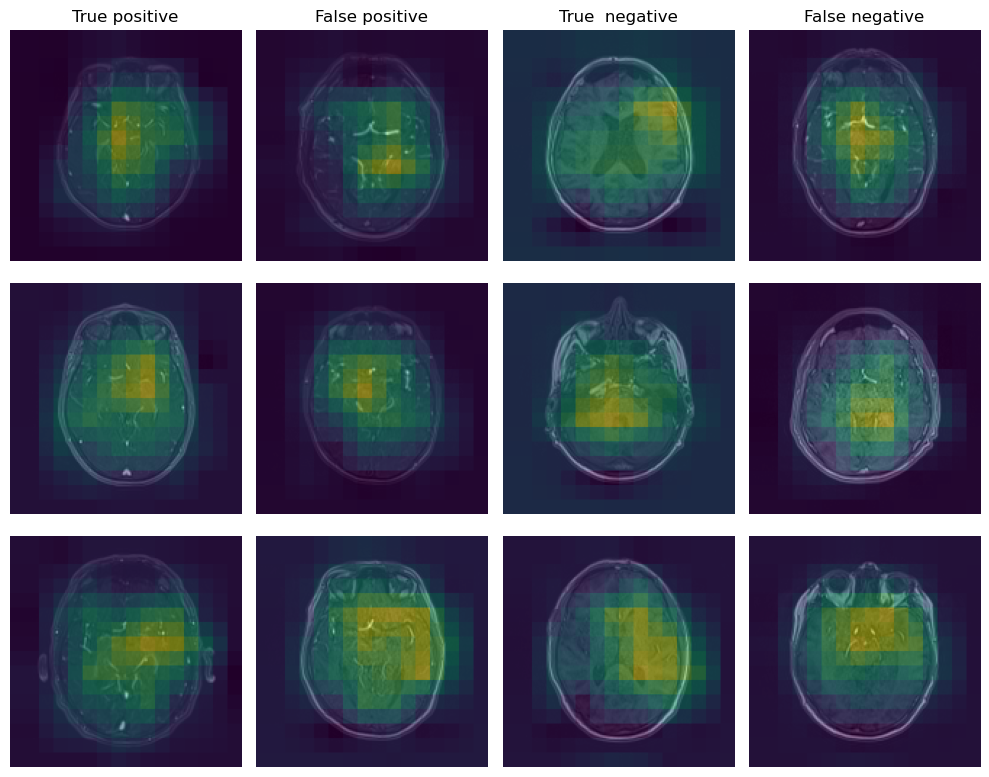

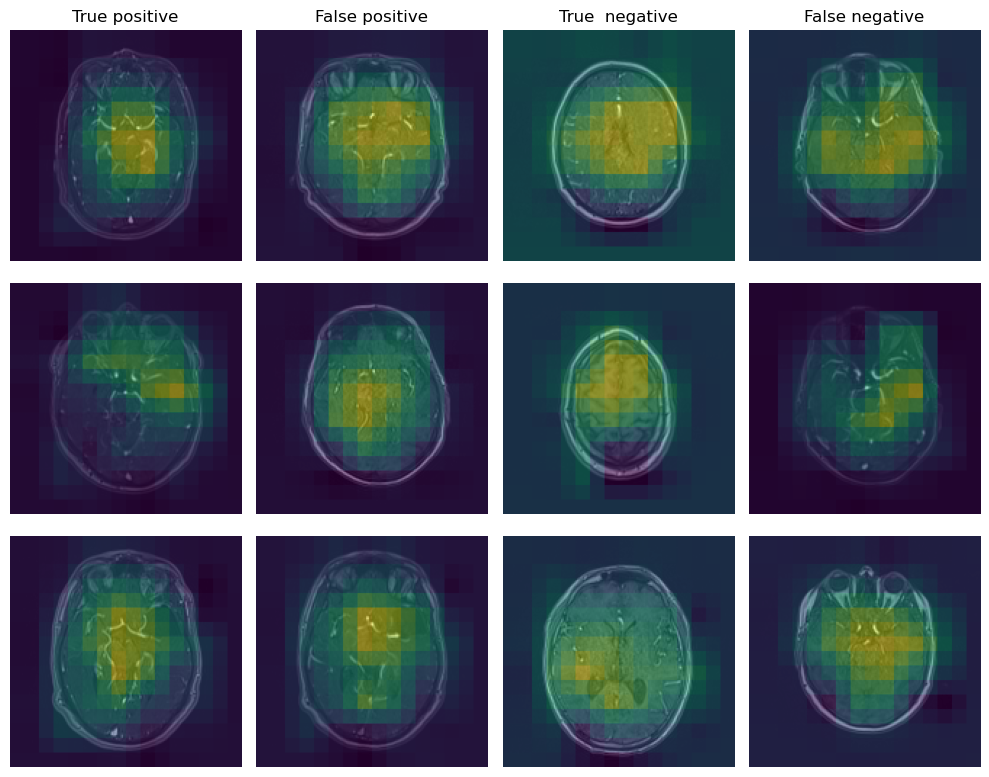

In [ ]:
from utils.visualization_utils import display_predictions
display_predictions(train_sorted, model, device, True)
display_predictions(val_sorted, model, device, True)


In [ ]:
val_FP, val_FN = pd.DataFrame(val_sorted[1]), pd.DataFrame(val_sorted[3])
train_FP, train_FN = pd.DataFrame(train_sorted[1]), pd.DataFrame(train_sorted[3])
name_val_slice_FP, count_val_slice_FP = np.unique(val_FP['Patient'], return_counts=True)
name_train_slice_FP, count_train_slice_FP = np.unique(train_FP['Patient'], return_counts=True)
slice_FP = {}
for i in [(name_val_slice_FP, count_val_slice_FP),(name_train_slice_FP, count_train_slice_FP)]:
    for v, c in zip(i[0],i[1]):
        if v in slice_FP:
            slice_FP[v] += c
            continue
        slice_FP[v] = c

In [ ]:
name_val_slice_FP

array([14, 16, 18, 27, 33, 59, 60], dtype=int64)

In [ ]:
val_FP[val_FP['Patient'] == 60]

,Patient,Volume,Slice,ImagePath
229949,60,13,18,D:/iCAT_IMAGES/060/060_22_594.dcm
229952,60,13,21,D:/iCAT_IMAGES/060/060_22_597.dcm


In [ ]:
mca_labels[(mca_labels['Patient'] == 59) & (mca_labels['Slice']== 20)]

,Patient,Slice,Label
1368,59,20,0
